Для выполнения лабораторной работы был выбран dataset акций компании BMV в период с 2013 по 2023 год

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as smt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn import metrics
from statsmodels.tsa.forecasting.theta import ThetaModel
from statsmodels.tsa.deterministic import DeterministicTerm
from typing import Tuple
import numpy as np

Предсказание будет сделано для Open Price
Удалили лишние столбцы и агрегировали по месяцам

In [3]:
stocks = pd.read_csv('data/BMW3.csv')
stocks = stocks.drop(['High', 'Close', 'Adj Close', 'Volume', 'Low'], axis=1)
stocks.Date = pd.to_datetime(stocks.Date, format='%Y-%m-%d')
stocks = stocks.resample('m', on='Date').mean()
stocks[:5]

,Open
Date,
2013-01-31,75.184998
2013-02-28,71.490500
2013-03-31,70.685500
2013-04-30,67.171427
2013-05-31,71.836819


<Axes: title={'center': 'Open Price'}, xlabel='Date', ylabel='Price'>

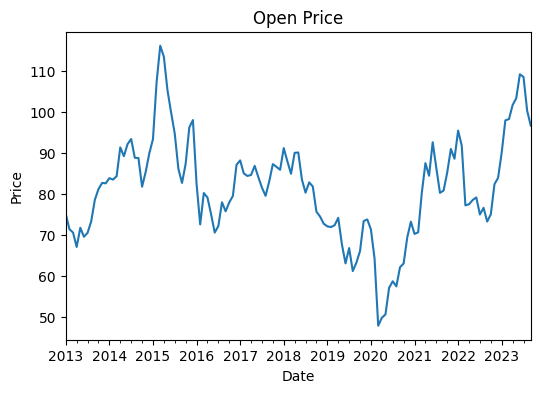

In [4]:
stocks.Open.plot(figsize=(6, 4), xlabel='Date', ylabel='Price', title='Open Price')

<Axes: title={'center': 'Residual'}, xlabel='Date'>

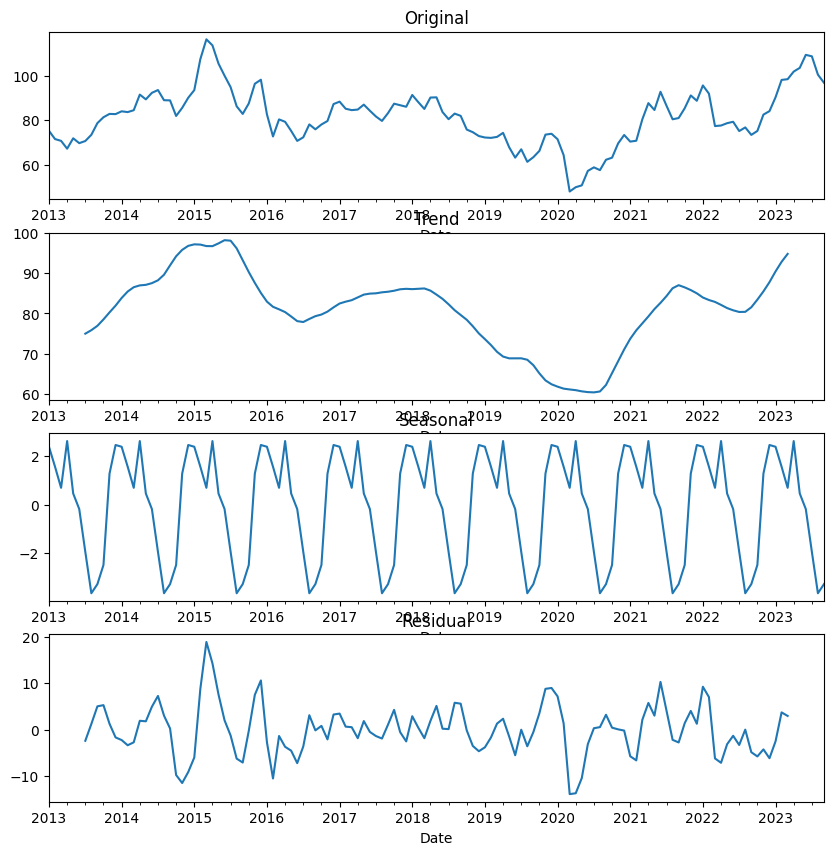

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
decompose = seasonal_decompose(stocks.Open, period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

Проверилии ряд на стационарность с помощью теста Дики-Фулера, тест показал, что ряд не стационарен

In [6]:
def diki_fuller_test(s):
    test = smt.tsa.adfuller(s)
    print('adf: ', test[0])
    print('p_value: ', test[1])
    print('critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [7]:
diki_fuller_test(stocks['Open'])

adf:  -2.4258285280136005
p_value:  0.1345787911256568
critical values:  {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
есть единичные корни, ряд не стационарен


Провели дифференцирование ряда для того, чтобы избавиться от тренда
Сразу написано обратное преобразование

In [8]:
def revert_diff(start, diff):
    a = diff.copy()
    a[0] = start
    return a.cumsum()

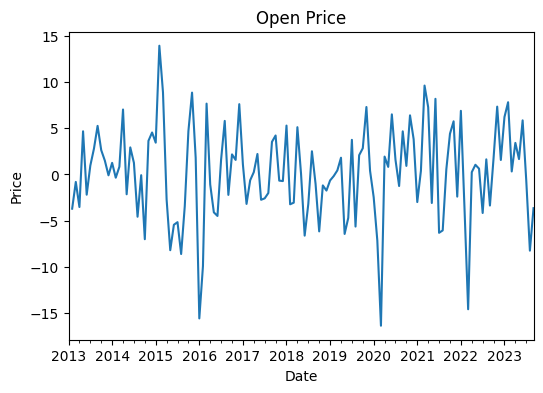

In [9]:
diff = stocks.diff()
diff.Open.plot(figsize=(6, 4), xlabel='Date', ylabel='Price', title='Open Price')
diff = diff[1::]

После дифференцирования ряда проводим тест Дики-Фулера

In [10]:
diki_fuller_test(diff['Open'])

adf:  -3.4545422722359125
p_value:  0.009234237522016799
critical values:  {'1%': -3.4865346059036564, '5%': -2.8861509858476264, '10%': -2.579896092790057}
единичных корней нет, ряд стационарен


Построили график автокорреляции

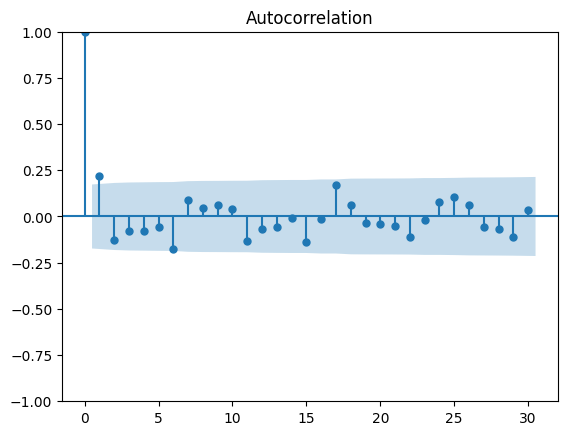

In [11]:
plot_acf(diff, lags=30)
plt.show()

In [12]:
len_df = len(diff)
len_train = int(len_df * 0.8)
len_test = len_df - len_train
train_data, test_data = diff[:len_train], diff[-len_test:]
split_date = stocks.index[len_train + 1]

Сделаем предсказание с помощью Theta Model из stats.models

In [13]:
model = ThetaModel(train_data, use_test=False)
model_fit = model.fit()
prediction = model_fit.forecast(len_test)
forecast = revert_diff(stocks.Open[len_train], prediction)
model_fit.summary()

C:\Users\doomb\AppData\Local\Temp\ipykernel_17032\464060590.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = revert_diff(stocks.Open[len_train], prediction)
C:\Users\doomb\AppData\Local\Temp\ipykernel_17032\787192794.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  a[0] = start


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ThetaModel Results                              
==============================================================================
Dep. Variable:                   Open   No. Observations:                  102
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Wed, 18 Oct 2023   Deseas. Method:               Additive
Time:                        12:21:53   Period:                             12
Sample:                    02-28-2013                                         
                         - 07-31-2021                                         
    Parameter Estimates    
===========================
            Parameters     
---------------------------
b0    0.0014000564661458006
alpha   0.05756256291888571
---------------------------
"""

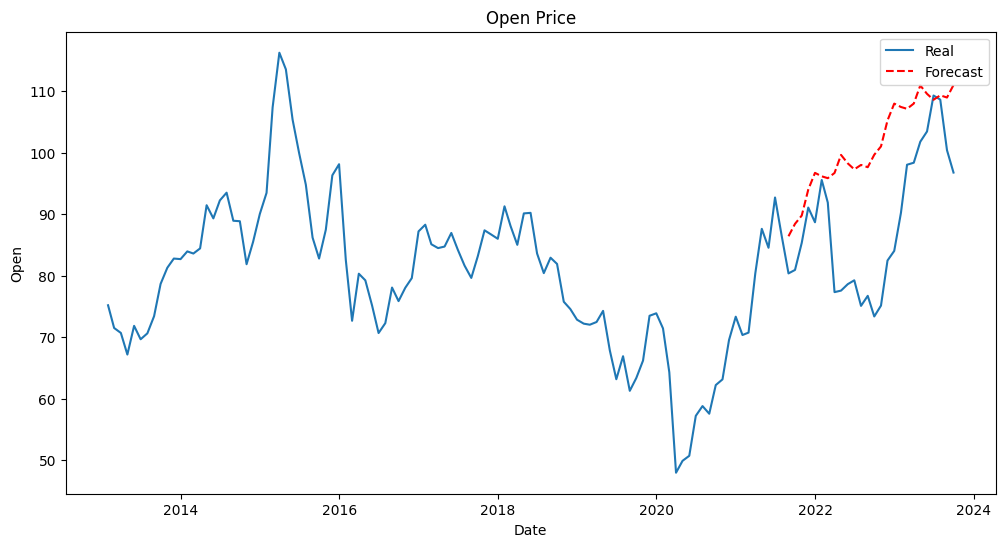

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(stocks.Open, label='Real')
plt.plot(forecast, label='Forecast', color='red', linestyle='--')
plt.title('Open Price')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend()
plt.show()

Проведем предсказание с помощью Theta Model, реализованной самостоятельно

In [21]:
def double_exp_smooth(data, alpha, beta):
    res = [data[0]]
    for i in range(1, len(data)):
        if i == 1:
            lev = data[0]
            trend = data[1] - data[0]
        if i > len(data):
            value = res[-1]
        else:
            value = data[i]

        last_lev, lev = lev, alpha * value + (1 - alpha) * (lev + trend)
        trend = beta * (lev - last_lev) + (1 - beta) * trend
        res.append(lev + trend)
    return res

In [19]:
class ThetaModelResult:

    def __init__(
            self,
            b0: float,
            alpha: float,
            one_step_forecast: float,
            seasonal: np.ndarray,
            model
    ) -> None:
        self._b0 = b0
        self._alpha = alpha
        self._one_step_forecast = one_step_forecast
        self._model = model
        self._nobs = model._data.shape[0]
        self._endog = self._model._endog
        self._period = self._model._period
        self._seasonal = seasonal

    def trend_weight(self, theta) -> float:
        thresh = 4.0 / np.finfo(np.double).eps
        return (theta - 1) / theta if theta < thresh else 1.0

    def forecast(self, horizon, theta=2) -> pd.Series:
        trend_weight = self.trend_weight(theta)
        comp = self.forecast_comp(horizon)
        return trend_weight * comp.trend + np.asarray(comp.ses) + np.asarray(comp.seasonal)

    def forecast_comp(self, horizon) -> pd.DataFrame:
        h = np.arange(1, horizon + 1, dtype=np.float64) - 1
        if self._alpha > 0:
            h += 1 / self._alpha - ((1 - self._alpha) ** self._nobs / self._alpha)
        season = np.zeros(horizon)
        season[:] = self._seasonal[(self._nobs + np.arange(horizon)) % self._period]
        index = DeterministicTerm._extend_index(getattr(self._endog, "index", None), horizon)
        df = pd.DataFrame(
            {"trend": self._b0 * h,
             "ses": self._one_step_forecast * np.ones(horizon),
             "seasonal": season},
            index=index
        )
        return df


class ThetaModelMan:
    def __init__(self, data) -> None:
        self._endog = data.iloc[:, 0]
        self._period = 12
        self._data = np.array(data.iloc[:, 0].array)

    def fit(self) -> ThetaModelResult:
        data, seasonal = self.deseasonalize()
        ct = self.add_constant_and_trend(data)[:, :2]
        ct[:, 1] -= 1
        a, b0 = np.linalg.lstsq(ct, data)[0]
        res = double_exp_smooth(data, 0.5, 0.05)
        return ThetaModelResult(b0, 0.5, res[-1], seasonal, self)

    def add_constant_and_trend(self, data):
        trend_array = np.fliplr(np.vander(np.arange(1, len(data) + 1, dtype=np.float64), 2))
        return np.column_stack([trend_array, data][::1])

    def define_decompose_method(self) -> str:
        return "mul" if self._data.min() > 0 else "add"

    def deseasonalize(self) -> Tuple[np.ndarray, np.ndarray]:
        method = self.define_decompose_method()
        decomposed = seasonal_decompose(self._data, model=method, period=self._period)
        if decomposed.seasonal.min() <= 0:
            decomposed = seasonal_decompose(self._data, model="add", period=self._period)
            return self._data - decomposed.seasonal, decomposed.seasonal[: self._period]
        else:
            return self._data / decomposed.seasonal, decomposed.seasonal[: self._period]

In [22]:
my_model = ThetaModelMan(train_data)
my_model_fit = my_model.fit()
my_prediction = my_model_fit.forecast(len_test)
my_forecast = revert_diff(stocks.Open[len_train], my_prediction)

C:\Users\doomb\AppData\Local\Temp\ipykernel_17032\582132622.py:55: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a, b0 = np.linalg.lstsq(ct, data)[0]
C:\Users\doomb\AppData\Local\Temp\ipykernel_17032\2804742920.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  my_forecast = revert_diff(stocks.Open[len_train], my_prediction)
C:\Users\doomb\AppData\Local\Temp\ipykernel_17032\787192794.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

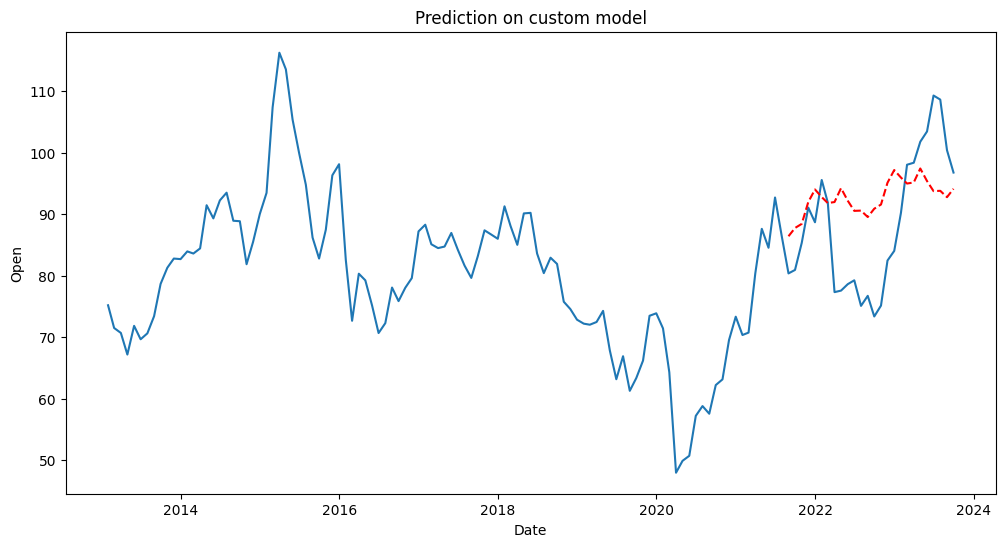

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(stocks.Open, label='Real')
plt.plot(my_forecast, label='Forecast', color='green', linestyle='--')
plt.title('Prediction on custom model')
plt.xlabel('Date')
plt.ylabel('Open')
plt.show()


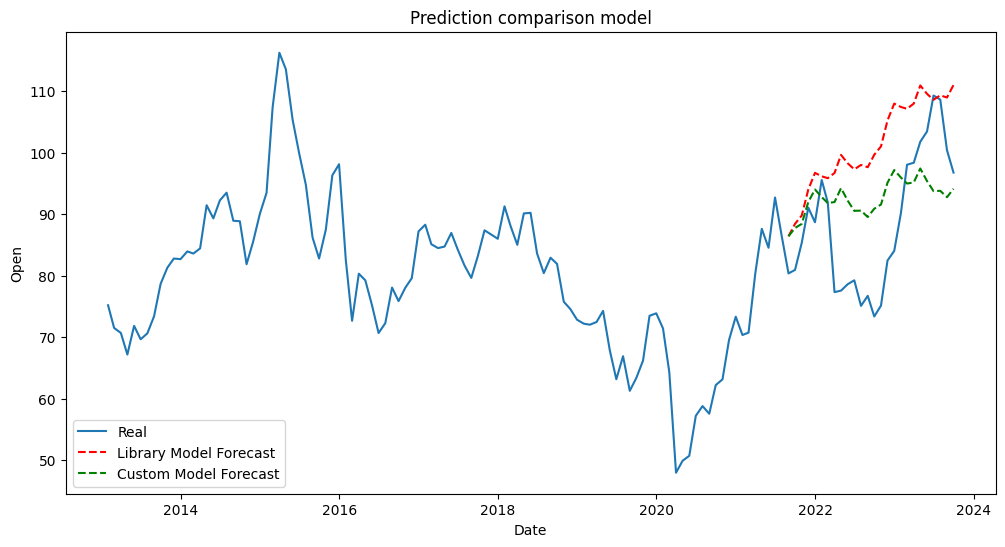

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(stocks.Open, label='Real')
plt.plot(forecast, label='Library Model Forecast', color='red', linestyle='--')
plt.plot(my_forecast, label='Custom Model Forecast', color='green', linestyle='--')
plt.title('Prediction comparison model')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend()

plt.show()


Сравним точности для моделей из библиотеки и самостоятельно реализованной с помощью метрик MAPE, MAE

In [30]:
print("Library Model ")
print("MAPE : " + str(metrics.mean_absolute_percentage_error(y_true=stocks[split_date:], y_pred=forecast)))
print("MAE : " + str(metrics.mean_absolute_error(y_true=stocks[split_date:], y_pred=forecast)))
print()
print("Custom model")
print("MAPE : " + str(metrics.mean_absolute_percentage_error(y_true=stocks[split_date:], y_pred=my_forecast)))
print("MAE : " + str(metrics.mean_absolute_error(y_true=stocks[split_date:], y_pred=my_forecast)))

Library Model 
MAPE : 0.1546691893130603
MAE : 12.718529979832928

Custom model
MAPE : 0.10712528984407627
MAE : 9.0106626645485
